In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings('ignore')

In [ ]:
path_single = r"/kaggle/input/landslide4sense/TrainData/img/image_2000.h5"
path_single_mask = r'/kaggle/input/landslide4sense/TrainData/mask/mask_2000.h5'

ls ['img']
input data shape: (128, 128, 14)


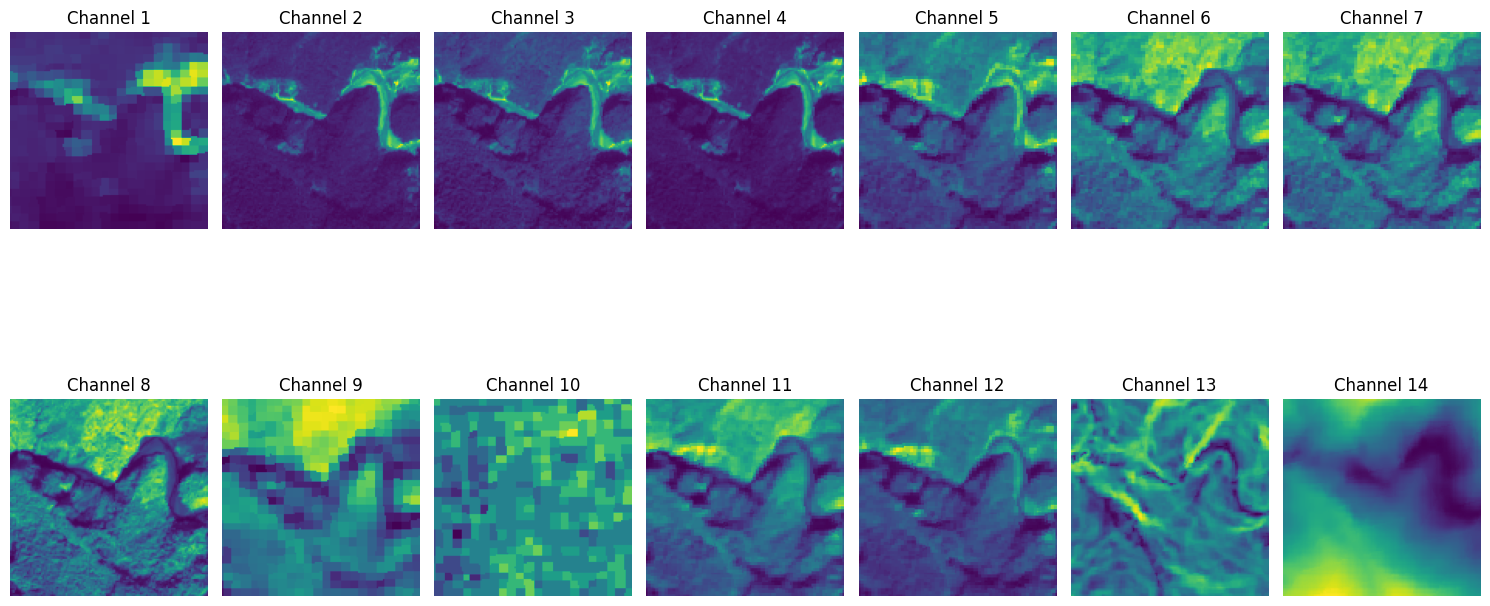

In [ ]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single, 'r') as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)

    fig, axes = plt.subplots(2, 7, figsize=(15, 9))
    axes = axes.ravel()

    for i in range(14):
        ax = axes[i]
        ax.imshow(data[:, :, i])
        ax.set_title(f"Channel {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

ls ['mask']
input data shape: (128, 128)


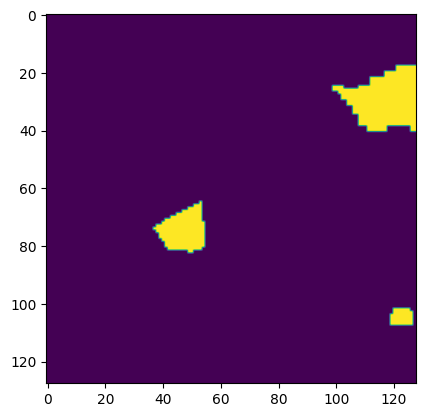

In [ ]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

In [ ]:
TRAIN_PATH = r"/kaggle/input/landslide4sense/TrainData/img/*.h5"
TRAIN_MASK = r"/kaggle/input/landslide4sense/TrainData/mask/*.h5"

TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

Data Preprocessing

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION


    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data


In [ ]:
# # TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
# TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
# print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

In [ ]:
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

In [ ]:
# print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

In [ ]:
img = 234
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0], cmap='gray')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.3, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True)

In [ ]:
x_train.shape, y_train.shape


In [ ]:
x_validation.shape, y_validation.shape

In [ ]:
x_test.shape, y_test.shape

In [ ]:
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask

In [ ]:
img=1545
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

In [ ]:
unet = unet_model(128, 128, 6)
# unet.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_unet.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')





In [ ]:
callbacks = [
    # earlyStopping,
    checkpointer
    ]
history = unet.fit(x_train, y_train, batch_size=16,
          epochs=100,
          verbose = 2,
          validation_data=(x_validation, y_validation),
          callbacks=callbacks)

In [ ]:
unet.save("unet_save.keras")

In [ ]:
loss, accuracy, f1_score, precision, recall = unet.evaluate(x_test, y_test, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

In [ ]:
loss, accuracy, f1_score, precision, recall = unet.evaluate(x_validation, y_validation, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

predictions

In [ ]:
# Create a figure and axis for the loss plot
plt.figure(figsize=(10, 6))  # Increased the figure size

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='orange')

# Set labels and legend
plt.xlabel('Epoch', fontsize=14)  # Increased the font size
plt.ylabel('Loss', fontsize=14)   # Increased the font size
#plt.title('Training and Validation Loss Over Epochs', fontsize=16)  # Increased the font size
plt.legend(loc='upper left', fontsize=12)  # Increased the font size

# Display the plot
plt.show()


In [ ]:
# Create a figure and axis for the precision plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision_m'], label='train', color='blue')
plt.plot(history.history['val_precision_m'], label='validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Create a figure and axis for the recall plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall_m'], label='train', color='blue')
plt.plot(history.history['val_recall_m'], label='validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Create a figure and axis for the F1 score plot
plt.figure(figsize=(10, 6))  # Increased the figure size

# Plot training and validation F1 score
plt.plot(history.history['f1_m'], label='Train', color='blue')
plt.plot(history.history['val_f1_m'], label='Validation', color='orange')

# Set labels and legend
plt.xlabel('Epoch', fontsize=14)  # Increased the font size
plt.ylabel('F1 Score', fontsize=14)  # Increased the font size
#plt.title('Training and Validation F1 Score Over Epochs', fontsize=16)  # Increased the font size
plt.legend(loc='upper left', fontsize=12)  # Increased the font size

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis for the accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train', color='blue')
plt.plot(history.history['val_accuracy'], label='validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Format the y-axis to show up to two decimal places
plt.gca().yaxis.set_major_formatter('{:.3f}'.format)

plt.show()

In [ ]:
threshold = 0.5
pred_img = unet.predict(x_test)
pred_img = (pred_img > threshold).astype(np.uint8)

In [ ]:
#releasing memory
del x_train
del y_train

In [ ]:
import matplotlib.pyplot as plt

img = 255
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))

# Display RGB image
ax1.imshow(x_test[img, :, :, 0:3])
ax1.axis('off')

# Display NDVI
ax2.imshow(x_test[img, :, :, 3])
ax2.axis('off')

# Display Slope
ax3.imshow(x_test[img, :, :, 4])
ax3.axis('off')

# Display Elevation
ax4.imshow(x_test[img, :, :, 5])
ax4.axis('off')

# Display Mask in black and white
ax5.imshow(y_test[img, :, :, 0], cmap='gray')
ax5.axis('off')

# Display Prediction in black and white
ax6.imshow(pred_img[img, :, :, 0], cmap='gray')
ax6.axis('off')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Determine the number of test images
num_test_images = x_test.shape[0]

for i in range(num_test_images):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))

    # Display RGB image
    ax1.imshow(x_test[i, :, :, 0:3])
    ax1.axis('off')

    # Display NDVI
    ax2.imshow(x_test[i, :, :, 3])
    ax2.axis('off')

    # Display Slope
    ax3.imshow(x_test[i, :, :, 4])
    ax3.axis('off')

    # Display Elevation
    ax4.imshow(x_test[i, :, :, 5])
    ax4.axis('off')

    # Display Mask in black and white
    ax5.imshow(y_test[i, :, :, 0], cmap='gray')
    ax5.axis('off')

    # Display Prediction in black and white
    ax6.imshow(pred_img[i, :, :, 0], cmap='gray')
    ax6.axis('off')

    plt.show()

In [ ]:
import matplotlib.pyplot as plt

img = 255
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))

# Display RGB image
ax1.imshow(x_test[img, :, :, 0:3])
ax1.set_title('RGB Image')

# Display NDVI
ax2.imshow(x_test[img, :, :, 3])
ax2.set_title('NDVI')

# Display Slope
ax3.imshow(x_test[img, :, :, 4])
ax3.set_title('Slope')

# Display Elevation
ax4.imshow(x_test[img, :, :, 5])
ax4.set_title('DEM')

# Display Mask in black and white
ax5.imshow(y_test[img, :, :, 0], cmap='gray')  # Using a grayscale colormap for Mask
ax5.set_title('Mask')

# Display Prediction in black and white
ax6.imshow(pred_img[img, :, :, 0], cmap='gray')  # Using a grayscale colormap for Prediction
ax6.set_title('Prediction')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

img = 33
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))

# Display RGB image
ax1.imshow(x_test[img, :, :, 0:3])
ax1.set_title('RGB Image')

# Display NDVI
ax2.imshow(x_test[img, :, :, 3])
ax2.set_title('NDVI')

# Display Slope
ax3.imshow(x_test[img, :, :, 4])
ax3.set_title('Slope')

# Display Elevation
ax4.imshow(x_test[img, :, :, 5])
ax4.set_title('DEM')

# Display Mask in black and white
ax5.imshow(y_test[img, :, :, 0], cmap='gray')  # Using a grayscale colormap for Mask
ax5.set_title('Mask')

# Display Prediction in black and white
ax6.imshow(pred_img[img, :, :, 0], cmap='gray')  # Using a grayscale colormap for Prediction
ax6.set_title('Prediction')

plt.show()

In [ ]:
unet.summary()

In [ ]:
img = 155
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

In [ ]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

In [ ]:
img = 167
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

# Resnet+ Unet

In [ ]:
import numpy as np
import glob
import h5py  # To read .h5 files

# Paths to training images and masks
TRAIN_PATH = r"/kaggle/input/landslide4sense/TrainData/img/*.h5"
TRAIN_MASK = r"/kaggle/input/landslide4sense/TrainData/mask/*.h5"

# Initialize arrays to store the data
TRAIN_XX = np.zeros((3799, 128, 128, 3))  # Input shape for ResNet: (H, W, 3)
TRAIN_YY = np.zeros((3799, 128, 128, 1))  # Masks should have a single channel

# Load and sort image and mask paths
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

# # Function to read .h5 files and extract data
# def read_h5(file_path):
#     with h5py.File(file_path, 'r') as f:
#         data = np.array(f['data'])  # Assuming 'data' is the key
#     return data

# # Load all images and masks into TRAIN_XX and TRAIN_YY
# for i, (img_path, mask_path) in enumerate(zip(all_train, all_mask)):
#     img = read_h5(img_path)  # Read the image
#     mask = read_h5(mask_path)  # Read the mask

#     # Resize if necessary (ensure input size is 128x128 for both images and masks)
#     if img.shape != (128, 128, 3):
#         img = tf.image.resize(img, (128, 128))  # Resize to (128, 128, 3)
#     if mask.shape != (128, 128, 1):
#         mask = tf.image.resize(mask, (128, 128))  # Resize mask to (128, 128, 1)

#     # Normalize the image to [0, 1]
#     TRAIN_XX[i] = img / 255.0

#     # Ensure the mask is binary (0 or 1)
#     TRAIN_YY[i] = (mask > 0.5).astype(np.float32)

# print(f"Training data shape: {TRAIN_XX.shape}")
# print(f"Training mask shape: {TRAIN_YY.shape}")


In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img, 'r') as hdf:
        # Read image data
        data = np.array(hdf.get('img'))

        # Assign 0 for the NaN values
        data[np.isnan(data)] = 0.000001

        # Normalize the data for RGB channels
        mid_rgb = data[:, :, 1:4].max() / 2.0

        # Final array construction
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED channel
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN channel
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE channel

    with h5py.File(mask, 'r') as hdf:
        # Read mask data
        data = np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data  # Binary mask

In [ ]:
# Handle NaN values in TRAIN_XX
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001

# Print min and max values of TRAIN_XX and TRAIN_YY
print("TRAIN_XX min:", TRAIN_XX.min(), "max:", TRAIN_XX.max())
print("TRAIN_YY min:", TRAIN_YY.min(), "max:", TRAIN_YY.max())

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.3, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True)

In [ ]:
# Visualization code
img_index = 1545  # Set the index of the image you want to visualize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))

# Set titles for each subplot
ax1.set_title("RGB Image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Mask")

# Display the RGB image
ax1.imshow(TRAIN_XX[img_index, :, :, 0:3])  # RGB channels

# Display the NDVI channel (placeholder for now since NDVI isn't calculated yet)
# You may need to add NDVI calculation here if required
# For visualization, just showing the RED channel for now
ndvi_display = (TRAIN_XX[img_index, :, :, 0] - TRAIN_XX[img_index, :, :, 0].min()) / (TRAIN_XX[img_index, :, :, 0].max() - TRAIN_XX[img_index, :, :, 0].min())
ax2.imshow(ndvi_display, cmap='gray')  # NDVI placeholder

# Display the Slope channel (placeholder for now)
# For visualization, just showing the GREEN channel for now
slope_display = (TRAIN_XX[img_index, :, :, 1] - TRAIN_XX[img_index, :, :, 1].min()) / (TRAIN_XX[img_index, :, :, 1].max() - TRAIN_XX[img_index, :, :, 1].min())
ax3.imshow(slope_display, cmap='gray')  # Slope placeholder

# Display the Mask
ax4.imshow(TRAIN_YY[img_index, :, :, 0], cmap='gray')  # Mask

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose
from tensorflow.keras.models import Model

def unet_resnet(input_shape=(128, 128, 3), num_classes=1):
    # Load a pretrained ResNet50 as the encoder, excluding the top layer.
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder (Feature Extraction from ResNet)
    c1 = resnet.get_layer('conv1_relu').output  # (64x64x64)
    c2 = resnet.get_layer('conv2_block3_out').output  # (32x32x256)
    c3 = resnet.get_layer('conv3_block4_out').output  # (16x16x512)
    c4 = resnet.get_layer('conv4_block6_out').output  # (8x8x1024)
    c5 = resnet.get_layer('conv5_block3_out').output  # (4x4x2048)

    # Decoder (Upsampling Path)
    u6 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c5)  # (8x8x1024) #(16)
    u6 = concatenate([u6, c4])  # (8x8x1024 + 8x8x1024)
    c6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)  # (16x16x512) #(32)
    u7 = concatenate([u7, c3])  # (16x16x512 + 16x16x512)
    c7 = Conv2D(512, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(512, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)  # (32x32x256) #(64)
    u8 = concatenate([u8, c2])  # (32x32x256 + 32x32x256)
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)  # (64x64x64) #(128)
    u9 = concatenate([u9, c1])  # (64x64x64 + 64x64x64)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Additional upsampling step to go from 64x64 to 128x128
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)  # (128x128x32)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(c10)

    # Final layer: Pixel-wise classification to match the input size
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c10)  # (128x128x1)


    # Model definition
    model1 = Model(inputs=[resnet.input], outputs=[outputs])
    model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model1

# Initialize the model and display summary
model1 = unet_resnet()
model1.summary()


In [ ]:
# ModelCheckpoint: Save the best model based on validation accuracy or F1-score
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "best_resnet_unet.keras",  # Save path for the model
    monitor="val_loss",        # Monitor validation loss (or choose a custom metric)
    verbose=1,
    save_best_only=True,       # Save only the best model
    mode="min"                 # 'min' because we want the minimum validation loss
)

# EarlyStopping: Stop training if no improvement for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Number of epochs with no improvement
    verbose=1,
    mode='min',                # Stop when the monitored value stops decreasing
    restore_best_weights=True  # Restore the best weights after stopping
)

# Callback list
callbacks = [
    early_stopping,
    checkpointer
]

history1 = model1.fit(x_train, y_train, batch_size=16,
          epochs=100,
          verbose = 2,
          validation_data=(x_validation, y_validation),
          callbacks=callbacks)


In [ ]:
# OR Save in HDF5 format (optional)
model1.save('unet_resnet.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict segmentation masks
y_pred = model1.predict(TRAIN_XX)  # Predict on the input images
y_pred = (y_pred > 0.5).astype("int32")  # Convert predictions to binary (0 or 1)

In [ ]:
# Step 2: Flatten predictions and ground truth for evaluation
y_pred_flat = y_pred.flatten()
y_true_flat = TRAIN_YY.flatten()


# Step 3: Calculate precision, recall, and F1-score

In [ ]:
precision = precision_score(y_true_flat, y_pred_flat, average='binary', zero_division=1)

In [ ]:
recall = recall_score(y_true_flat, y_pred_flat, average='binary', zero_division=1)

In [ ]:
f1 = f1_score(y_true_flat, y_pred_flat, average='binary', zero_division=1)

In [ ]:
# Step 4: Print the evaluation metrics
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


In [ ]:
# Optional: Visualize one of the predictions along with the ground truth
img_index = 1545  # Index of the image to visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image (RGB)
ax1.set_title("RGB Image")
ax1.imshow(TRAIN_XX[img_index, :, :, 0:3])

# Display the predicted mask
ax2.set_title("Predicted Mask")
ax2.imshow(y_pred[img_index, :, :, 0], cmap='gray')

# Display the ground truth mask
ax3.set_title("Ground Truth Mask")
ax3.imshow(TRAIN_YY[img_index, :, :, 0], cmap='gray')

# Adjust layout
plt.tight_layout()
plt.show()


# BISDENET

In [ ]:
import numpy as np
import glob
import h5py  # To read .h5 files

# Paths to training images and masks
TRAIN_PATH = r"/kaggle/input/landslide4sense/TrainData/img/*.h5"
TRAIN_MASK = r"/kaggle/input/landslide4sense/TrainData/mask/*.h5"

# Initialize arrays to store the data
TRAIN_XX = np.zeros((3799, 128, 128, 3))  # Input shape for ResNet: (H, W, 3)
TRAIN_YY = np.zeros((3799, 128, 128, 1))  # Masks should have a single channel

# Load and sort image and mask paths
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img, 'r') as hdf:
        # Read image data
        data = np.array(hdf.get('img'))

        # Assign 0 for the NaN values
        data[np.isnan(data)] = 0.000001

        # Normalize the data for RGB channels
        mid_rgb = data[:, :, 1:4].max() / 2.0

        # Final array construction
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED channel
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN channel
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE channel

    with h5py.File(mask, 'r') as hdf:
        # Read mask data
        data = np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data  # Binary mask

0 /kaggle/input/landslide4sense/TrainData/img/image_1.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1.h5
1 /kaggle/input/landslide4sense/TrainData/img/image_10.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_10.h5
2 /kaggle/input/landslide4sense/TrainData/img/image_100.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_100.h5
3 /kaggle/input/landslide4sense/TrainData/img/image_1000.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1000.h5
4 /kaggle/input/landslide4sense/TrainData/img/image_1001.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1001.h5
5 /kaggle/input/landslide4sense/TrainData/img/image_1002.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1002.h5
6 /kaggle/input/landslide4sense/TrainData/img/image_1003.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1003.h5
7 /kaggle/input/landslide4sense/TrainData/img/image_1004.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1004.h5
8 /kaggle/input/landslide4sense/TrainData/img/image_1005.h5 /kaggle/

In [ ]:
# Handle NaN values in TRAIN_XX
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001

# Print min and max values of TRAIN_XX and TRAIN_YY
print("TRAIN_XX min:", TRAIN_XX.min(), "max:", TRAIN_XX.max())
print("TRAIN_YY min:", TRAIN_YY.min(), "max:", TRAIN_YY.max())

TRAIN_XX min: -1.0 max: 1.0
TRAIN_YY min: 0.0 max: 1.0


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.3, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

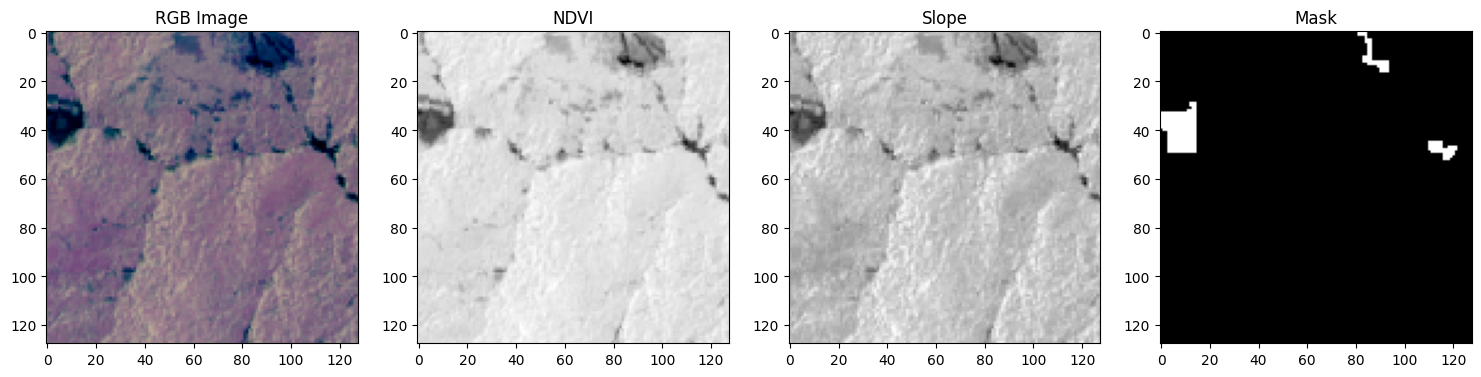

In [ ]:
# Visualization code
img_index = 1545  # Set the index of the image you want to visualize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))

# Set titles for each subplot
ax1.set_title("RGB Image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Mask")

# Display the RGB image
ax1.imshow(TRAIN_XX[img_index, :, :, 0:3])  # RGB channels

# Display the NDVI channel (placeholder for now since NDVI isn't calculated yet)
# You may need to add NDVI calculation here if required
# For visualization, just showing the RED channel for now
ndvi_display = (TRAIN_XX[img_index, :, :, 0] - TRAIN_XX[img_index, :, :, 0].min()) / (TRAIN_XX[img_index, :, :, 0].max() - TRAIN_XX[img_index, :, :, 0].min())
ax2.imshow(ndvi_display, cmap='gray')  # NDVI placeholder

# Display the Slope channel (placeholder for now)
# For visualization, just showing the GREEN channel for now
slope_display = (TRAIN_XX[img_index, :, :, 1] - TRAIN_XX[img_index, :, :, 1].min()) / (TRAIN_XX[img_index, :, :, 1].max() - TRAIN_XX[img_index, :, :, 1].min())
ax3.imshow(slope_display, cmap='gray')  # Slope placeholder

# Display the Mask
ax4.imshow(TRAIN_YY[img_index, :, :, 0], cmap='gray')  # Mask

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

def bisdenet(input_shape=(128, 128, 3), num_classes=1):
    # Load a pretrained ResNet50 as the encoder, excluding the top layer.
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder (Feature Extraction from ResNet)
    c1 = resnet.get_layer('conv1_relu').output  # (64x64x64)
    c2 = resnet.get_layer('conv2_block3_out').output  # (32x32x256)
    c3 = resnet.get_layer('conv3_block4_out').output  # (16x16x512)
    c4 = resnet.get_layer('conv4_block6_out').output  # (8x8x1024)
    c5 = resnet.get_layer('conv5_block3_out').output  # (4x4x2048)

    # Bidirectional Decoder (Upsampling Path with Attention)
    # Decoder layer 1
    u6 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])  # Applying attention between the upsampled layer and the corresponding encoder layer
    c6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)

    # Decoder layer 2
    u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(512, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(512, (3, 3), activation='relu', padding='same')(c7)

    # Decoder layer 3
    u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same')(c8)

    # Decoder layer 4
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Additional upsampling step to go from 64x64 to 128x128
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(c10)

    # Final layer: Pixel-wise classification to match the input size
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c10)

    # Model definition
    model = Model(inputs=[resnet.input], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the model and display summary
model2 = bisdenet()
model2.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 71,965,121 (274.53 MB)

 Trainable params: 71,912,001 (274.32 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# ModelCheckpoint: Save the best model based on validation accuracy or F1-score
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "best_bisdenet_model.keras",  # Updated save path for the BisDeNet model
    monitor="val_loss",           # Monitor validation loss (or choose a custom metric)
    verbose=1,
    save_best_only=True,          # Save only the best model
    mode="min"                    # 'min' because we want the minimum validation loss
)

# EarlyStopping: Stop training if no improvement for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=10,                  # Number of epochs with no improvement
    verbose=1,
    mode='min',                   # Stop when the monitored value stops decreasing
    restore_best_weights=True     # Restore the best weights after stopping
)

# Callback list
callbacks = [
    early_stopping,
    checkpointer
]

# Train the BisDeNet model
history = model2.fit(
    x_train, y_train,
    batch_size=16,
    epochs=100,
    verbose=1,
    validation_data=(x_validation, y_validation),
    callbacks=callbacks
)


Epoch 1/100


I0000 00:00:1730829694.264754     106 service.cc:145] XLA service 0x7dadd8002780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730829694.264808     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/167 ━━━━━━━━━━━━━━━━━━━━ 3:34:19 77s/step - accuracy: 0.8834 - loss: 0.5240

I0000 00:00:1730829734.736690     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9748 - loss: 0.0908

I0000 00:00:1730829785.751997     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 172 bytes spill stores, 172 bytes spill loads




Epoch 1: val_loss improved from inf to 0.22744, saving model to best_bisdenet_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 143s 393ms/step - accuracy: 0.9748 - loss: 0.0907 - val_accuracy: 0.9766 - val_loss: 0.2274
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9787 - loss: 0.0698
Epoch 2: val_loss did not improve from 0.22744
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9787 - loss: 0.0704 - val_accuracy: 0.9766 - val_loss: 4633901056.0000
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9773 - loss: 0.1190
Epoch 3: val_loss improved from 0.22744 to 0.14350, saving model to best_bisdenet_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9773 - loss: 0.1219 - val_accuracy: 0.9766 - val_loss: 0.1435
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9765 - loss: 0.1755
Epoch 4: val_loss did not improve from 0.14350
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9765 - loss: 0.1750 - val_

In [ ]:
# Assuming you have the accuracy and loss values stored in variables
accuracy = 0.9860
loss = 0.0356
val_accuracy = 0.9839
val_loss = 0.0433

# Print the values
print("Final Training Accuracy:", accuracy)
print("Final Training Loss:", loss)
print("Final Validation Accuracy:", val_accuracy)
print("Final Validation Loss:", val_loss)

Final Training Accuracy: 0.986
Final Training Loss: 0.0356
Final Validation Accuracy: 0.9839
Final Validation Loss: 0.0433


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict segmentation masks
y_pred = model2.predict(TRAIN_XX)  # Predict on the input images
y_pred = (y_pred > 0.5).astype("int32")  # Convert predictions to binary (0 or 1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step


In [ ]:
# Step 2: Flatten predictions and ground truth for evaluation
y_pred_flat = y_pred.flatten()
y_true_flat = TRAIN_YY.flatten()

In [ ]:
precision = precision_score(y_true_flat, y_pred_flat, average='binary', zero_division=1)


In [ ]:
recall = recall_score(y_true_flat, y_pred_flat, average='binary', zero_division=1)


In [ ]:
f1 = f1_score(y_true_flat, y_pred_flat, average='binary', zero_division=1)


In [ ]:
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


Precision: 0.8073504583886418, Recall: 0.4961720000831722, F1-Score: 0.614618780218615


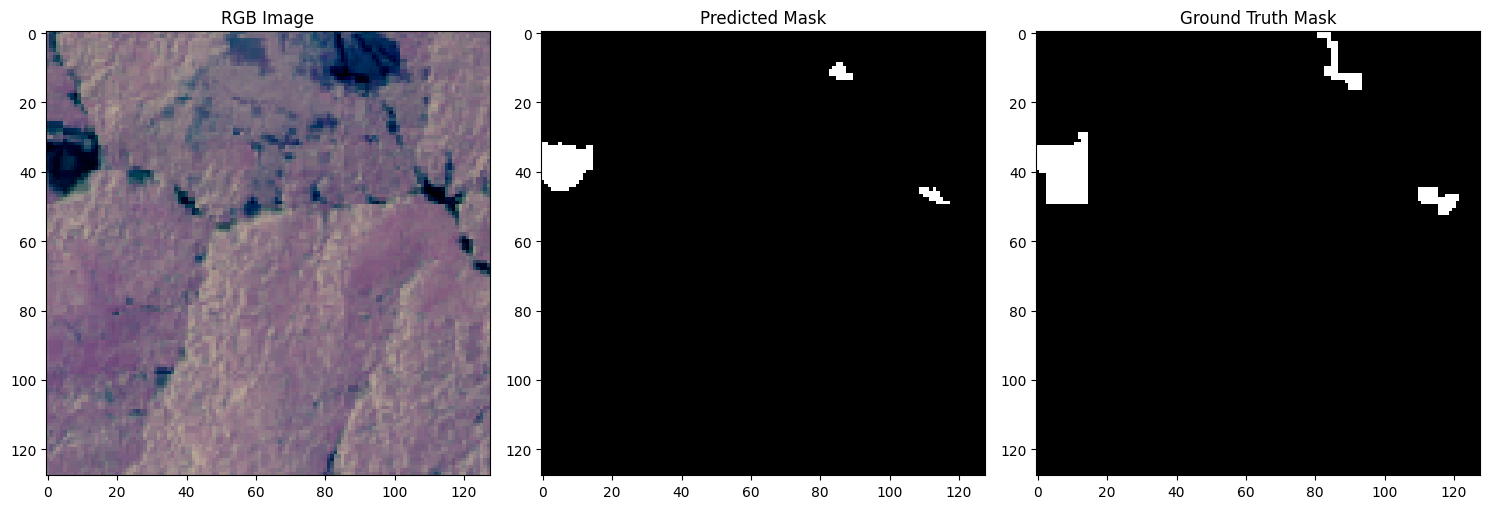

In [ ]:
# Optional: Visualize one of the predictions along with the ground truth
img_index = 1545  # Index of the image to visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image (RGB)
ax1.set_title("RGB Image")
ax1.imshow(TRAIN_XX[img_index, :, :, 0:3])

# Display the predicted mask
ax2.set_title("Predicted Mask")
ax2.imshow(y_pred[img_index, :, :, 0], cmap='gray')

# Display the ground truth mask
ax3.set_title("Ground Truth Mask")
ax3.imshow(TRAIN_YY[img_index, :, :, 0], cmap='gray')

# Adjust layout
plt.tight_layout()
plt.show()
